# Creates gif of the evolution of the training process
The plot contains two subplots
- Level sets of the predictions of the model at epoch
- Loss at epoch

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(0,2000)
print(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

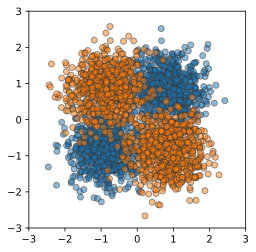

In [2]:
data_noise = 0.3
plotlim = [-3, 3]
subfolder = 'evo_xor'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('xor', noise = data_noise, plotlim = plotlim, random_state= seed)


In [3]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-1.5594, -0.3070],
        [ 1.0033,  0.3835],
        [ 0.2223, -0.0034],
        [ 1.0500, -1.2797],
        [ 1.2462, -1.5412],
        [-0.0808, -1.4579],
        [-0.4321,  1.4309],
        [-0.0905, -0.0600],
        [-0.4065, -0.3644],
        [ 2.3041,  1.6789]]) tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0])


# Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

In [5]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
        (6): Linear(in_features=2, out_features=2, bias=True)
        (7): Linear(in_features=2, out_features=2, bias=True)
        (8): Linear(in_features=2, out_features=2, bias=True)
        (9): Linear(in_features=2, out_features=2, bias=True)
        (10): Linear(in_features=2, out_features=2, bias=True)
        (11): Linear(in_features=2, out_features=2, bias=True)
        (12): Linear(in_features=2, out_features=2, bias=True)
        (13): Linear(in_features=2, out_features=2, bias=True)
        (14

# Training and generating level sets

In [6]:
from models.training import Trainer, doublebackTrainer
from plots.plots import train_to_classifier_imgs

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 10

eps = 0.2

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)

0.2

Iteration 0/45
Loss: 0.770
Robust Term Loss: 0.032
Accuracy: 0.609

Iteration 10/45
Loss: 0.850
Robust Term Loss: 0.041
Accuracy: 0.516

Iteration 20/45
Loss: 0.721
Robust Term Loss: 0.030
Accuracy: 0.578

Iteration 30/45
Loss: 0.837
Robust Term Loss: 0.040
Accuracy: 0.391

Iteration 40/45
Loss: 0.683
Robust Term Loss: 0.027
Accuracy: 0.531
Epoch 1: 0.792
0.2

Iteration 0/45
Loss: 0.663
Robust Term Loss: 0.020
Accuracy: 0.609

Iteration 10/45
Loss: 0.691
Robust Term Loss: 0.029
Accuracy: 0.516

Iteration 20/45
Loss: 0.673
Robust Term Loss: 0.027
Accuracy: 0.578

Iteration 30/45
Loss: 0.700
Robust Term Loss: 0.030
Accuracy: 0.391

Iteration 40/45
Loss: 0.666
Robust Term Loss: 0.033
Accuracy: 0.625
Epoch 2: 0.687
0.2

Iteration 0/45
Loss: 0.664
Robust Term Loss: 0.031
Accuracy: 0.625

Iteration 10/45
Loss: 0.660
Robust Term Loss: 0.039
Accuracy: 0.609

Iteration 20/45
Loss: 0.663
Robust Term Loss: 0.036
Accuracy: 0.609

Iteration 30/45
Loss: 0.658
Robust Term Loss: 0.041
Accuracy: 0

In [7]:
from models.training import Trainer, doublebackTrainer

trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')

0.2

Iteration 0/45
Loss: 0.648
Robust Term Loss: 0.032
Accuracy: 0.609

Iteration 10/45
Loss: 0.721
Robust Term Loss: 0.040
Accuracy: 0.516

Iteration 20/45
Loss: 0.608
Robust Term Loss: 0.030
Accuracy: 0.578

Iteration 30/45
Loss: 0.708
Robust Term Loss: 0.038
Accuracy: 0.391

Iteration 40/45
Loss: 0.575
Robust Term Loss: 0.027
Accuracy: 0.531
Epoch 1: 0.667
0.2

Iteration 0/45
Loss: 0.550
Robust Term Loss: 0.019
Accuracy: 0.609

Iteration 10/45
Loss: 0.579
Robust Term Loss: 0.025
Accuracy: 0.516

Iteration 20/45
Loss: 0.564
Robust Term Loss: 0.024
Accuracy: 0.578

Iteration 30/45
Loss: 0.595
Robust Term Loss: 0.028
Accuracy: 0.391

Iteration 40/45
Loss: 0.564
Robust Term Loss: 0.027
Accuracy: 0.578
Epoch 2: 0.579
0.2

Iteration 0/45
Loss: 0.556
Robust Term Loss: 0.021
Accuracy: 0.625

Iteration 10/45
Loss: 0.563
Robust Term Loss: 0.026
Accuracy: 0.594

Iteration 20/45
Loss: 0.561
Robust Term Loss: 0.024
Accuracy: 0.594

Iteration 30/45
Loss: 0.572
Robust Term Loss: 0.024
Accuracy: 0

# Loss plots

trainer_rnode.eps = 0.2
epoch = 0


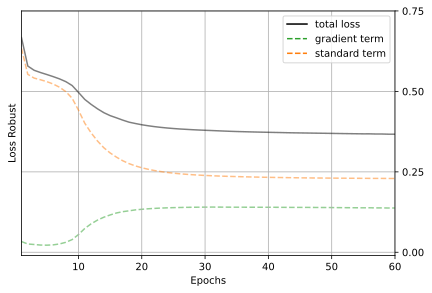

no filename given


In [8]:
from enum import auto

from plots.plots import loss_evolution
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 0)

epoch = 5


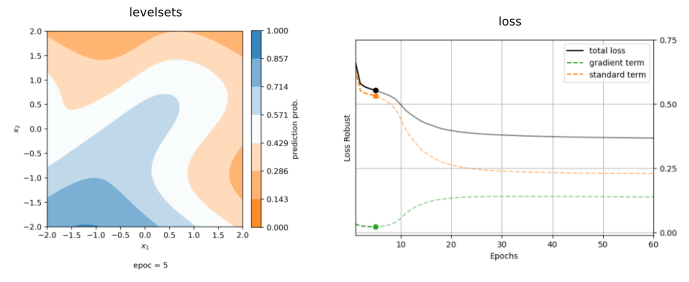

In [9]:
from plots.plots import comparison_plot
import os

epoch = 5
fig_name_base = os.path.join(subfolder, '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (10,4))

## gif generation

In [10]:
from plots.gifs import evo_gif
gif = evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, '', keep = [5,10])

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
evo_xor/evo.gif  created


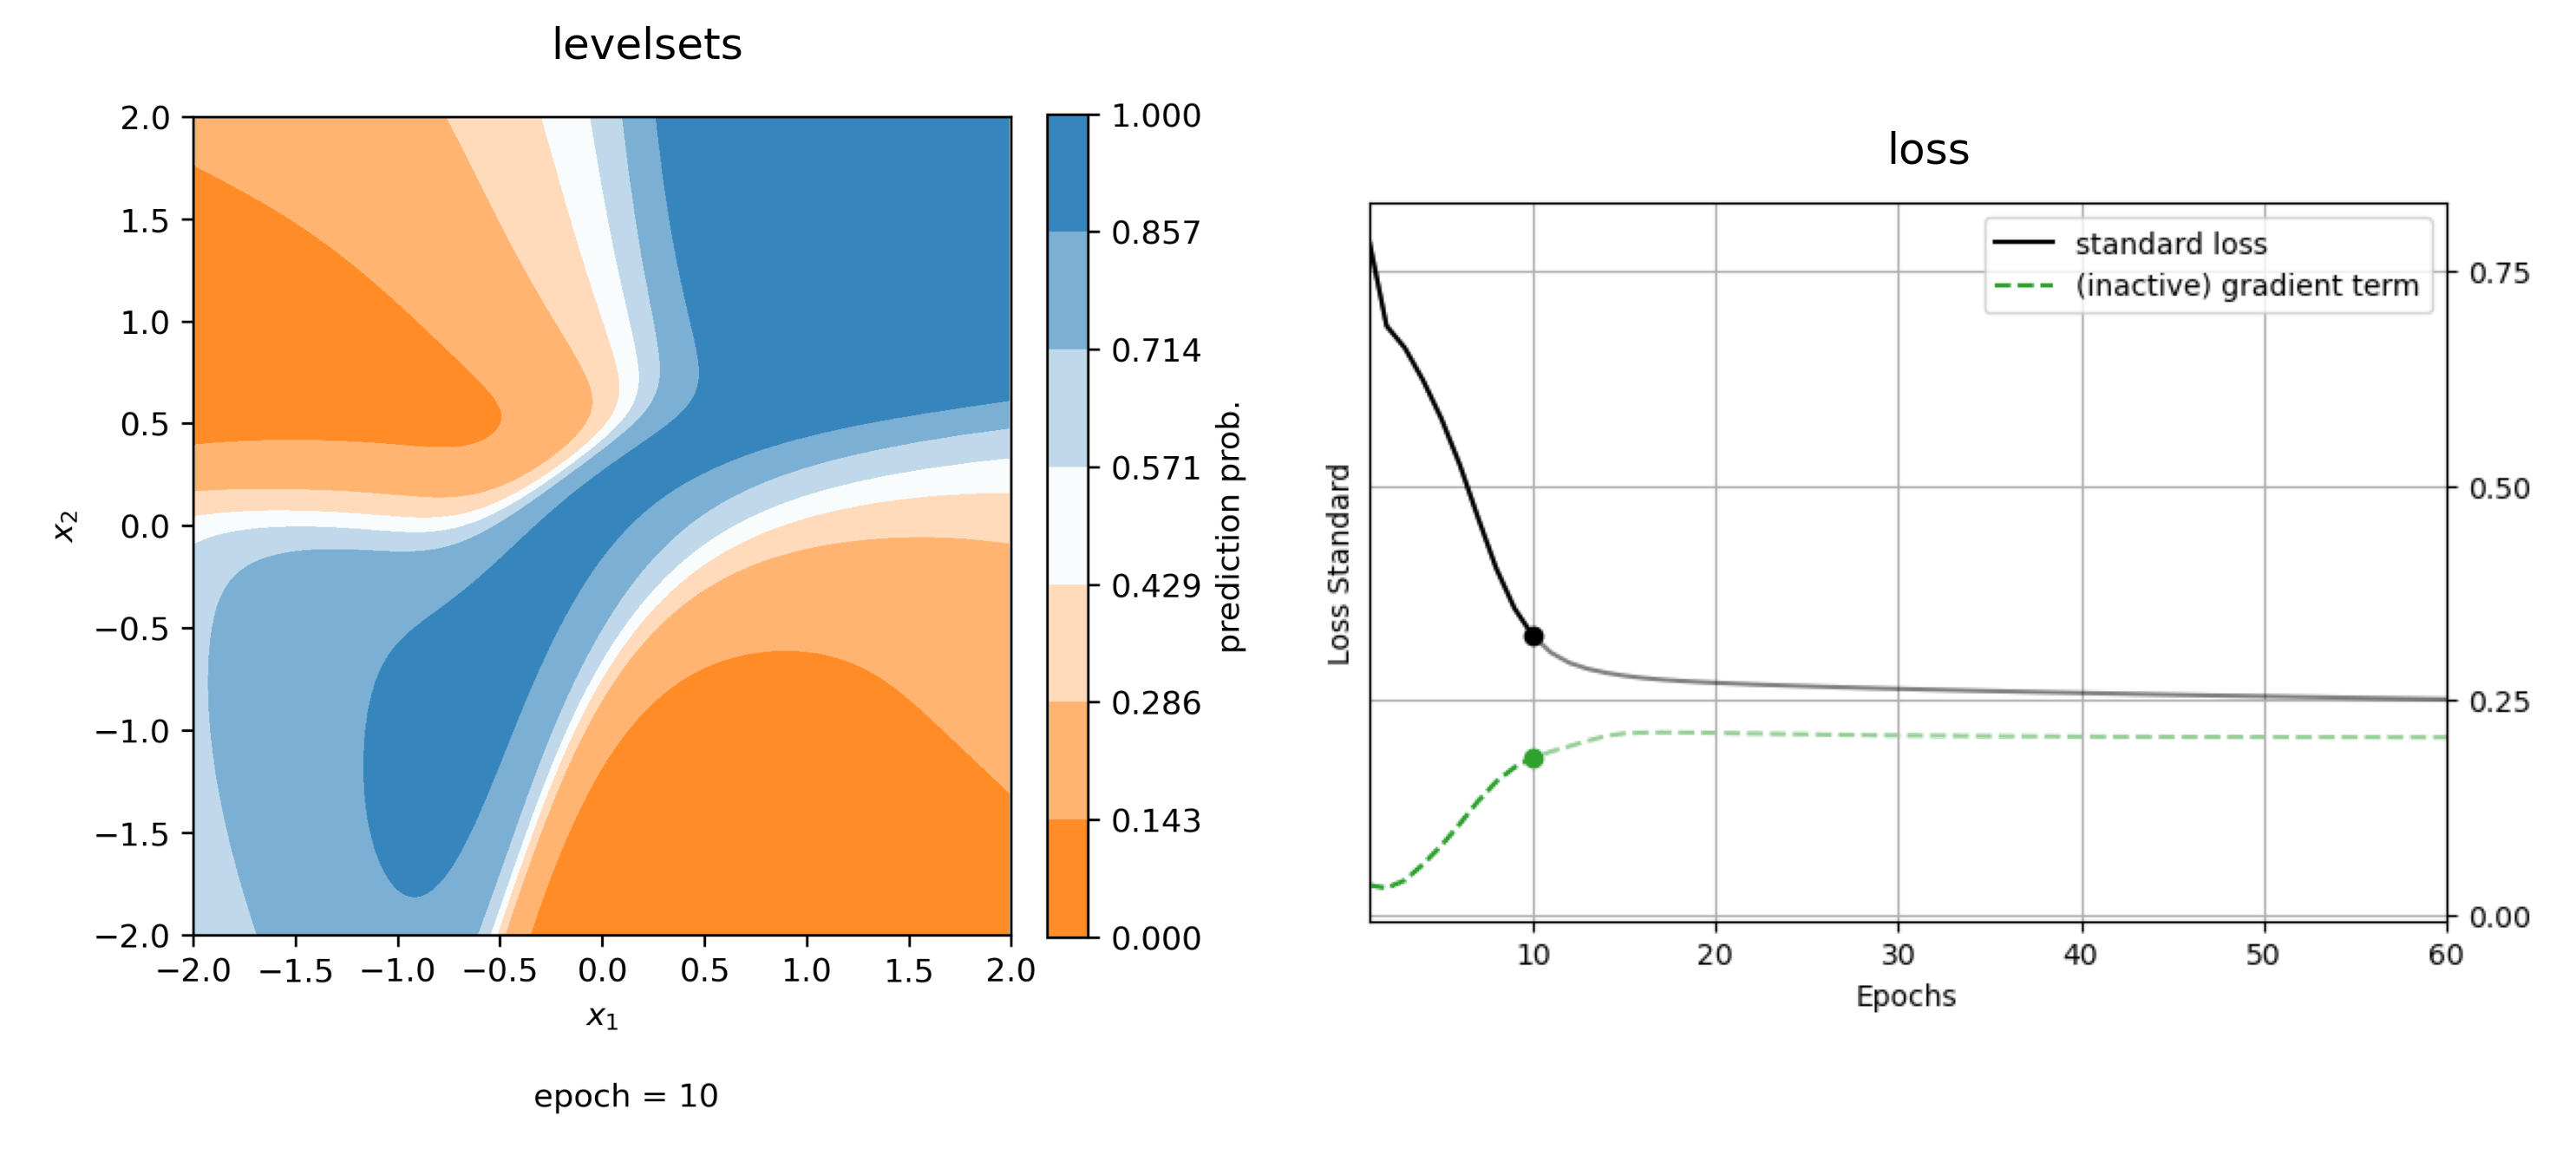

In [11]:
from IPython.display import Image
Image(filename = gif, width = 800)

10
epoch = 10
20
epoch = 20
30
epoch = 30
40
epoch = 40
50
epoch = 50
60
epoch = 60
evo_xor/robevo.gif  created


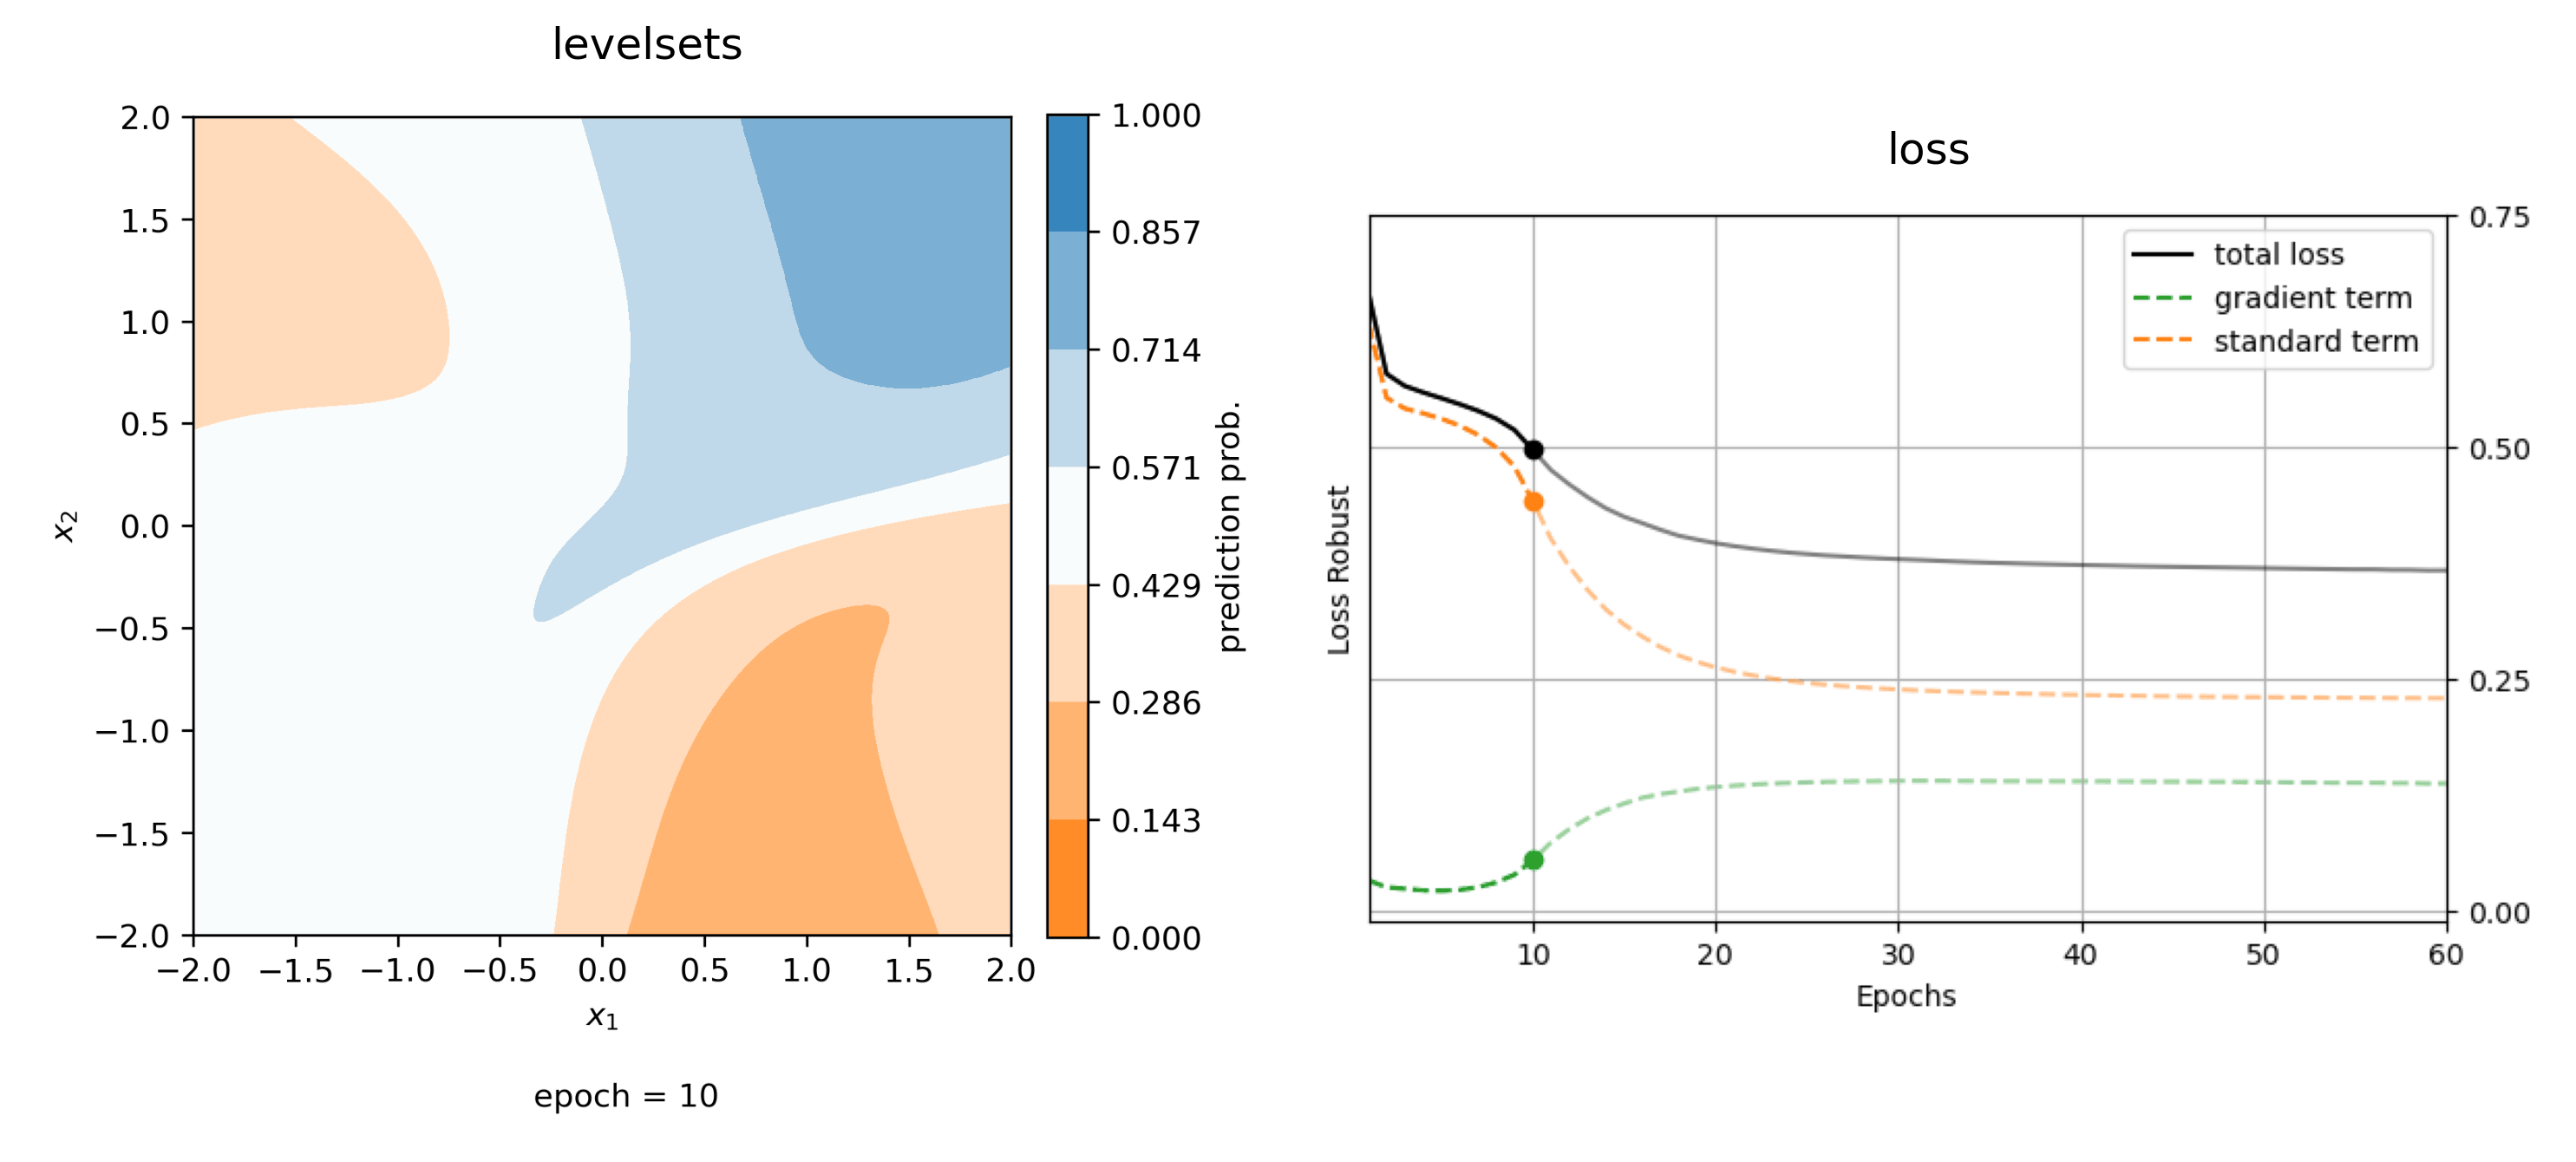

In [12]:
rob_gif = evo_gif(trainer_rnode, num_epochs, plotfreq, subfolder, 'rob')

from IPython.display import Image
Image(filename = rob_gif, width = 800)